In [1]:
from functions import *
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from pathlib import Path

import pingouin as pg
import seaborn as sns

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr
from scipy.stats import linregress


In [2]:
# Define paths
BASE_PATH = Path("Z:/yueying/psychedeLights_YueyingDong")
PSYCHOPY_PATH = BASE_PATH / "results/data/psychopy"
SACC_CLEAN_PATH = BASE_PATH / "results/data/saccClean"
GAZE_CLEAN_PATH = BASE_PATH / "results/data/gazeClean"


In [25]:
sacc_clean_files = glob.glob(str(SACC_CLEAN_PATH / "*.csv"))
saccClean = pd.concat(
    [pd.read_csv(f).iloc[:, 1:] for f in sacc_clean_files],
    axis=0,
    ignore_index=True
)
print(f"  Loaded {len(saccClean)} trials from {len(sacc_clean_files)} files")

print("\n✓ Data loading complete!")

  Loaded 35924 trials from 3 files

✓ Data loading complete!


In [8]:
gaze_clean_files = glob.glob(str(GAZE_CLEAN_PATH / "*.csv"))
gazeClean = pd.concat(
    [pd.read_csv(f) for f in gaze_clean_files],
    axis=0,
    ignore_index=True
)
print(f"  Loaded {len(gazeClean)} trials from {len(gaze_clean_files)} files")

print("\n✓ Data loading complete!")

  Loaded 18112 trials from 2 files

✓ Data loading complete!


In [5]:
psyFull = pd.read_csv('./psychopy/psyFull.csv')

# Figure 4A

In [12]:
gazeTemp = gazeClean.reset_index().merge(psyFull[['TRIALID','cuedItem',]]).set_index(['cuedItem','axis'])

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_24828\1760433172.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  allX = gazeTemp.iloc[:,4001:7501].loc['left','x'].to_numpy().flatten()-960
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_24828\1760433172.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  allY = gazeTemp.iloc[:,4001:7501].loc['left','y'].to_numpy().flatten()-520


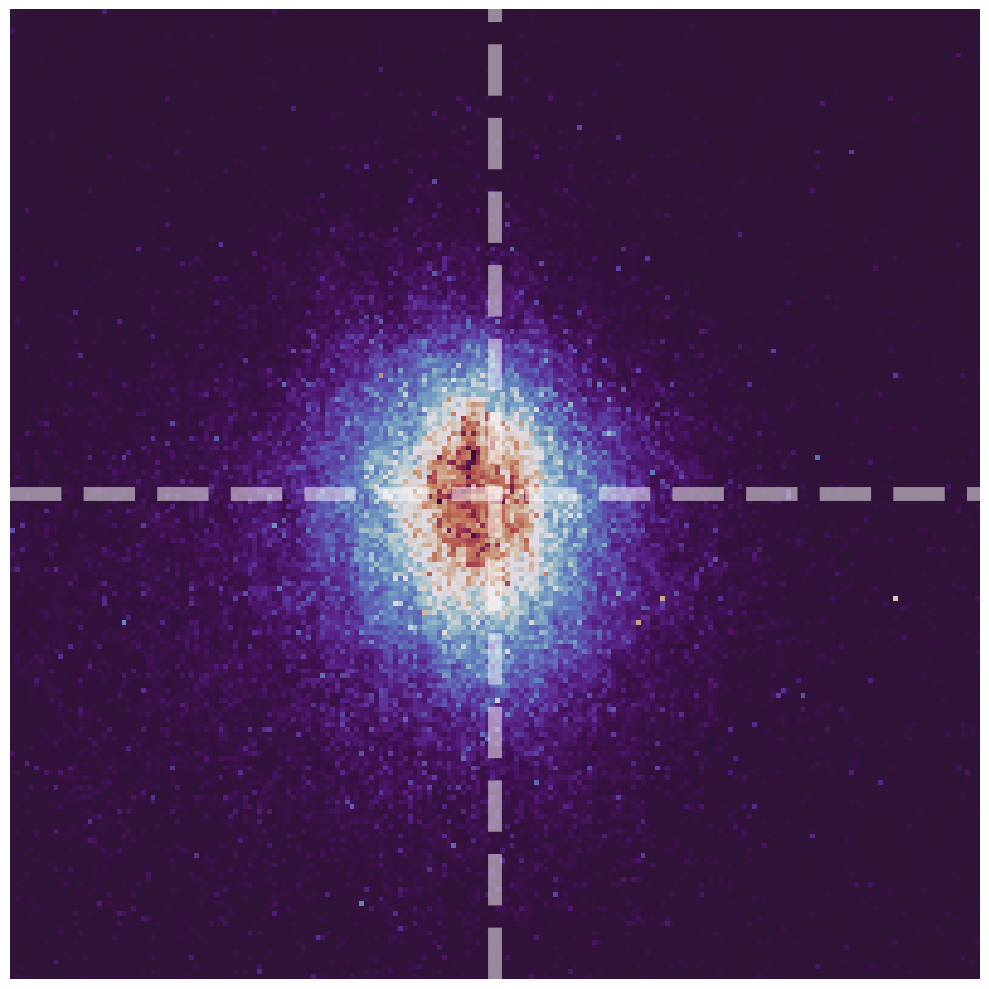

In [14]:
fs(10,10)

allX = gazeTemp.iloc[:,4001:7501].loc['left','x'].to_numpy().flatten()-960
allY = gazeTemp.iloc[:,4001:7501].loc['left','y'].to_numpy().flatten()-520

fig,ax = plt.subplots(1)
leftVal = plt.hist2d(allX, allY, bins = (200,200),
                         range = [[-100, 100], [-100, 100]], density=True,cmap = 'twilight_shifted')[0]
plt.vlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)
plt.hlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)

plt.axis('off')

plt.tick_params(labelsize = 40)
fig.tight_layout()
plt.show()


C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_24828\453335880.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  allX = gazeTemp.iloc[:,4001:7501].loc['right','x'].to_numpy().flatten()-960
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_24828\453335880.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  allY = gazeTemp.iloc[:,4001:7501].loc['right','y'].to_numpy().flatten()-520


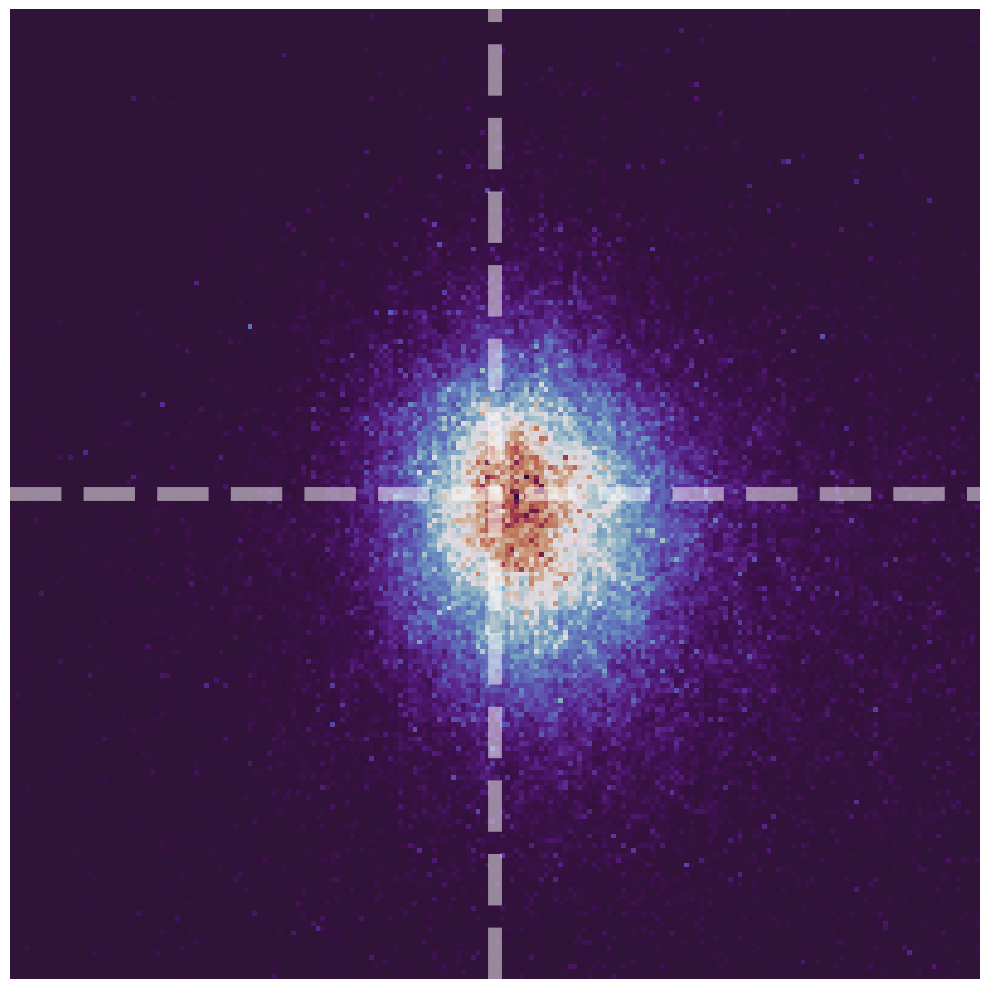

In [15]:
fs(10,10)

allX = gazeTemp.iloc[:,4001:7501].loc['right','x'].to_numpy().flatten()-960
allY = gazeTemp.iloc[:,4001:7501].loc['right','y'].to_numpy().flatten()-520

fig,ax = plt.subplots(1)
rightVal = plt.hist2d(allX, allY, bins = (200,200),
                         range = [[-100, 100], [-100, 100]], density=True,cmap = 'twilight_shifted')[0]
plt.vlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)
plt.hlines(0,-100,100,linestyles='dashed',colors = 'white',linewidth = 10,alpha = 0.5)


plt.axis('off')

plt.tick_params(labelsize = 40)
fig.tight_layout()
plt.show()


(-0.5, 210.025, 210.025, -0.5)

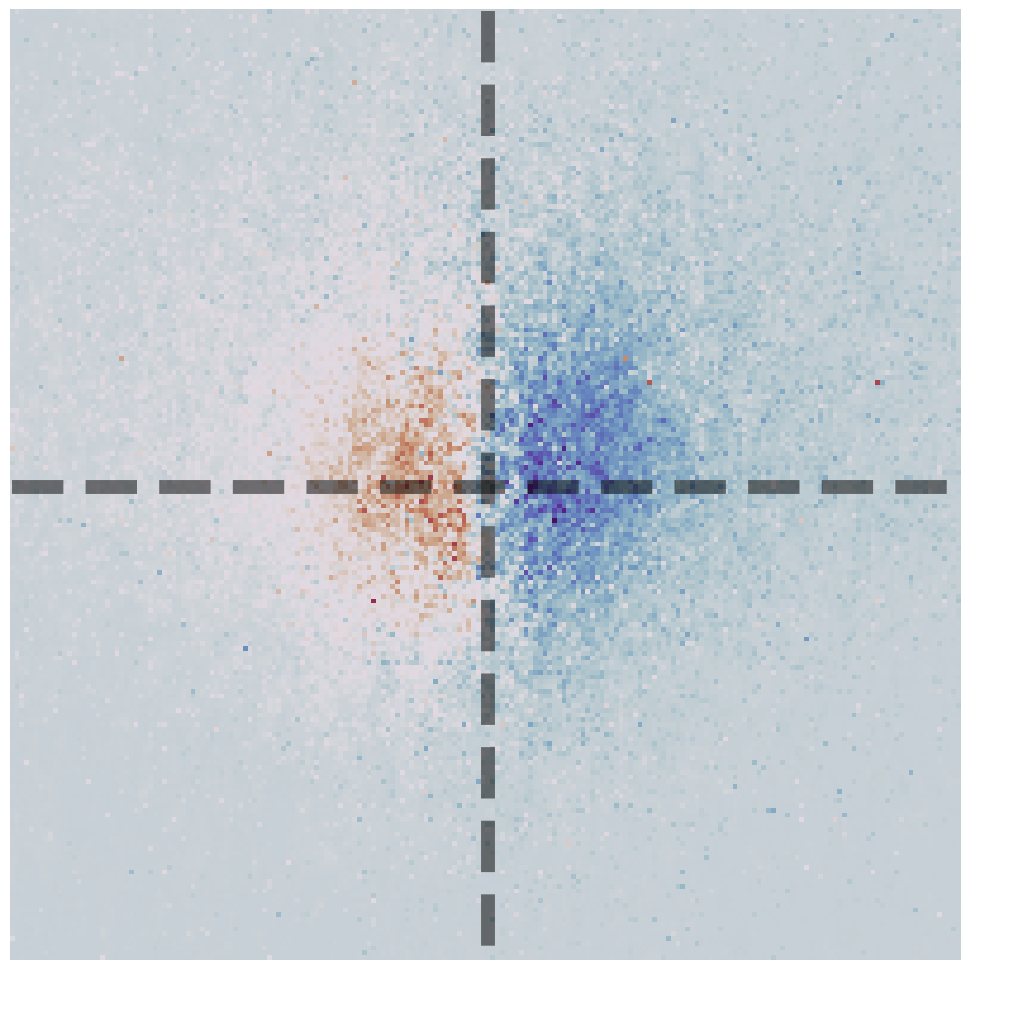

In [16]:
fs(13,13)

plt.imshow((leftVal - rightVal).T,cmap='twilight_shifted',vmin = -0.00032,vmax = 0.0004)
plt.vlines(100,0,200,linestyles='dashed',colors = 'black',linewidth = 10,alpha = 0.5)
plt.hlines(100,0,200,linestyles='dashed',colors = 'black',linewidth = 10,alpha = 0.5)

plt.axis('off')


# Figure 4B

In [29]:
gazeClean.set_index('axis',inplace=True)

In [30]:
shift_df = calculate_gaze_shifts(gazeClean)

GAZE SHIFT CALCULATION

Step 1: Smoothing gaze data (window=51)...
  Smoothed 9056 trials
Step 2: Detecting gaze shifts (threshold=6px)...
Step 3: Filtering shifts (X≥8px or Y≥8px)...
  Detected 167,123 X-shifts and 167,120 Y-shifts
Step 4: Formatting output...

GAZE SHIFT CALCULATION COMPLETE
Output shape: (18112, 8002)
Trials with shifts: 9056


In [31]:
shiftDf = shift_df[shift_df.axis == 'x'].iloc[:,1:].merge(psyFull[['TRIALID','cuedItem']],on='TRIALID')
shiftDf = shiftDf.set_index('cuedItem')

toward = shiftDf.copy()
away = shiftDf.copy()

leftAll = toward.loc['left'].iloc[:,2:].values
toward.loc['left',toward.columns[2:]] = np.where(leftAll < 0,1,0)
rightAll = toward.loc['right'].iloc[:,2:].values
toward.loc['right',toward.columns[2:]] = np.where(rightAll > 0,1,0)

leftAll = away.loc['left'].iloc[:,2:].values
away.loc['left',away.columns[2:]] = np.where(leftAll > 0,1,0)
rightAll = away.loc['right'].iloc[:,2:].values
away.loc['right', away.columns[2:]] = np.where(rightAll <0,1,0)

#get frequency
winsize = 100
freq = 1000
towardFreq = toward.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize
awayFreq = away.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize

towardFreq.insert(0,'TRIALID',toward.TRIALID)
awayFreq.insert(0,'TRIALID',away.TRIALID)
towardFreq['towardness'] = 'toward'
awayFreq['towardness'] = 'away'
towardnessDf = pd.concat([towardFreq,awayFreq],axis = 0)
towardnessDf = towardnessDf.reset_index()
towardnessDf = towardnessDf.merge(psyFull[['trlType','TRIALID']])

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_24828\3830987711.py:20: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  towardFreq = toward.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize
C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_24828\3830987711.py:21: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  awayFreq = away.iloc[:,1:].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize


In [32]:
qq = towardnessDf.groupby(['towardness','trlType']).mean(numeric_only=True)
qqSd = towardnessDf.groupby(['towardness','trlType']).sem(numeric_only=True)

saccUpper = qq + qqSd
saccLower = qq - qqSd

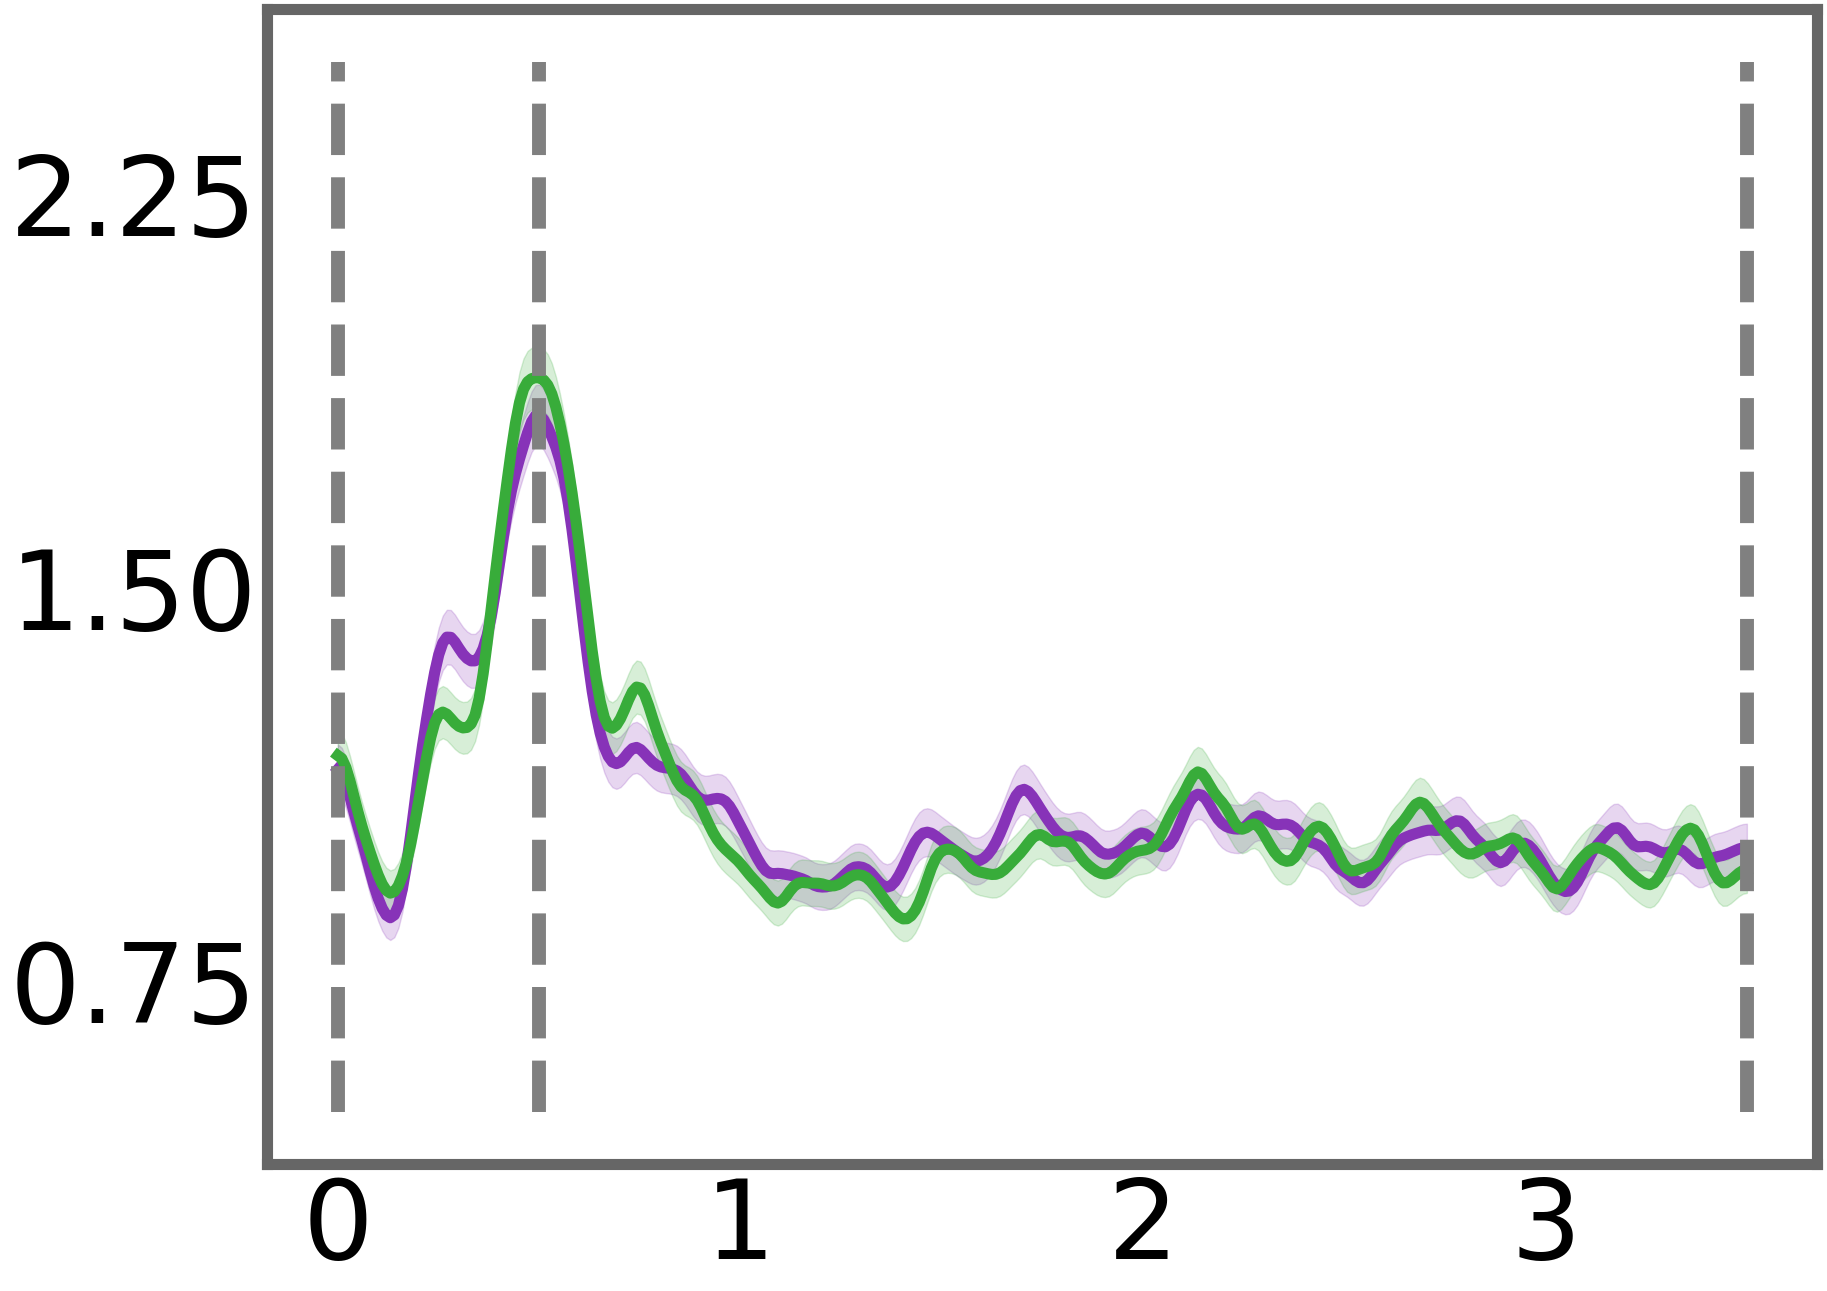

In [33]:
fs(20,15)
fig,ax = plt.subplots()

lenData = 350
x = np.linspace(0,3.5,lenData)
[plt.plot(x,smooth_signal(qq.iloc[i,4001:7501:10],11),c = ["#8733b8","#38ac3a",][i%2],linestyle = ['dotted','-'][i//2],alpha=[0.8,0.8,1,1,][i],linewidth = 8) for i in [2,3]];
[plt.fill_between(x,smooth_signal(saccUpper.iloc[i,4001:7501:10]),
                       smooth_signal(saccLower.iloc[i,4001:7501:10]),alpha = 0.2,color = ["#8733b8","#38ac3a",][i%2]) for i in [2,3]]



plt.vlines([0,0.5,3.5],0.5,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.75))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)

In [34]:
towardnessDf_bri = towardnessDf.merge(psyFull[['TRIALID','cuedItemBri','participant']],how = 'left')
qq = towardnessDf_bri.groupby(['towardness','cuedItemBri']).mean(numeric_only=True)
qqSd = towardnessDf_bri.groupby(['towardness','cuedItemBri']).sem(numeric_only=True)

saccUpper = qq + qqSd
saccLower = qq - qqSd

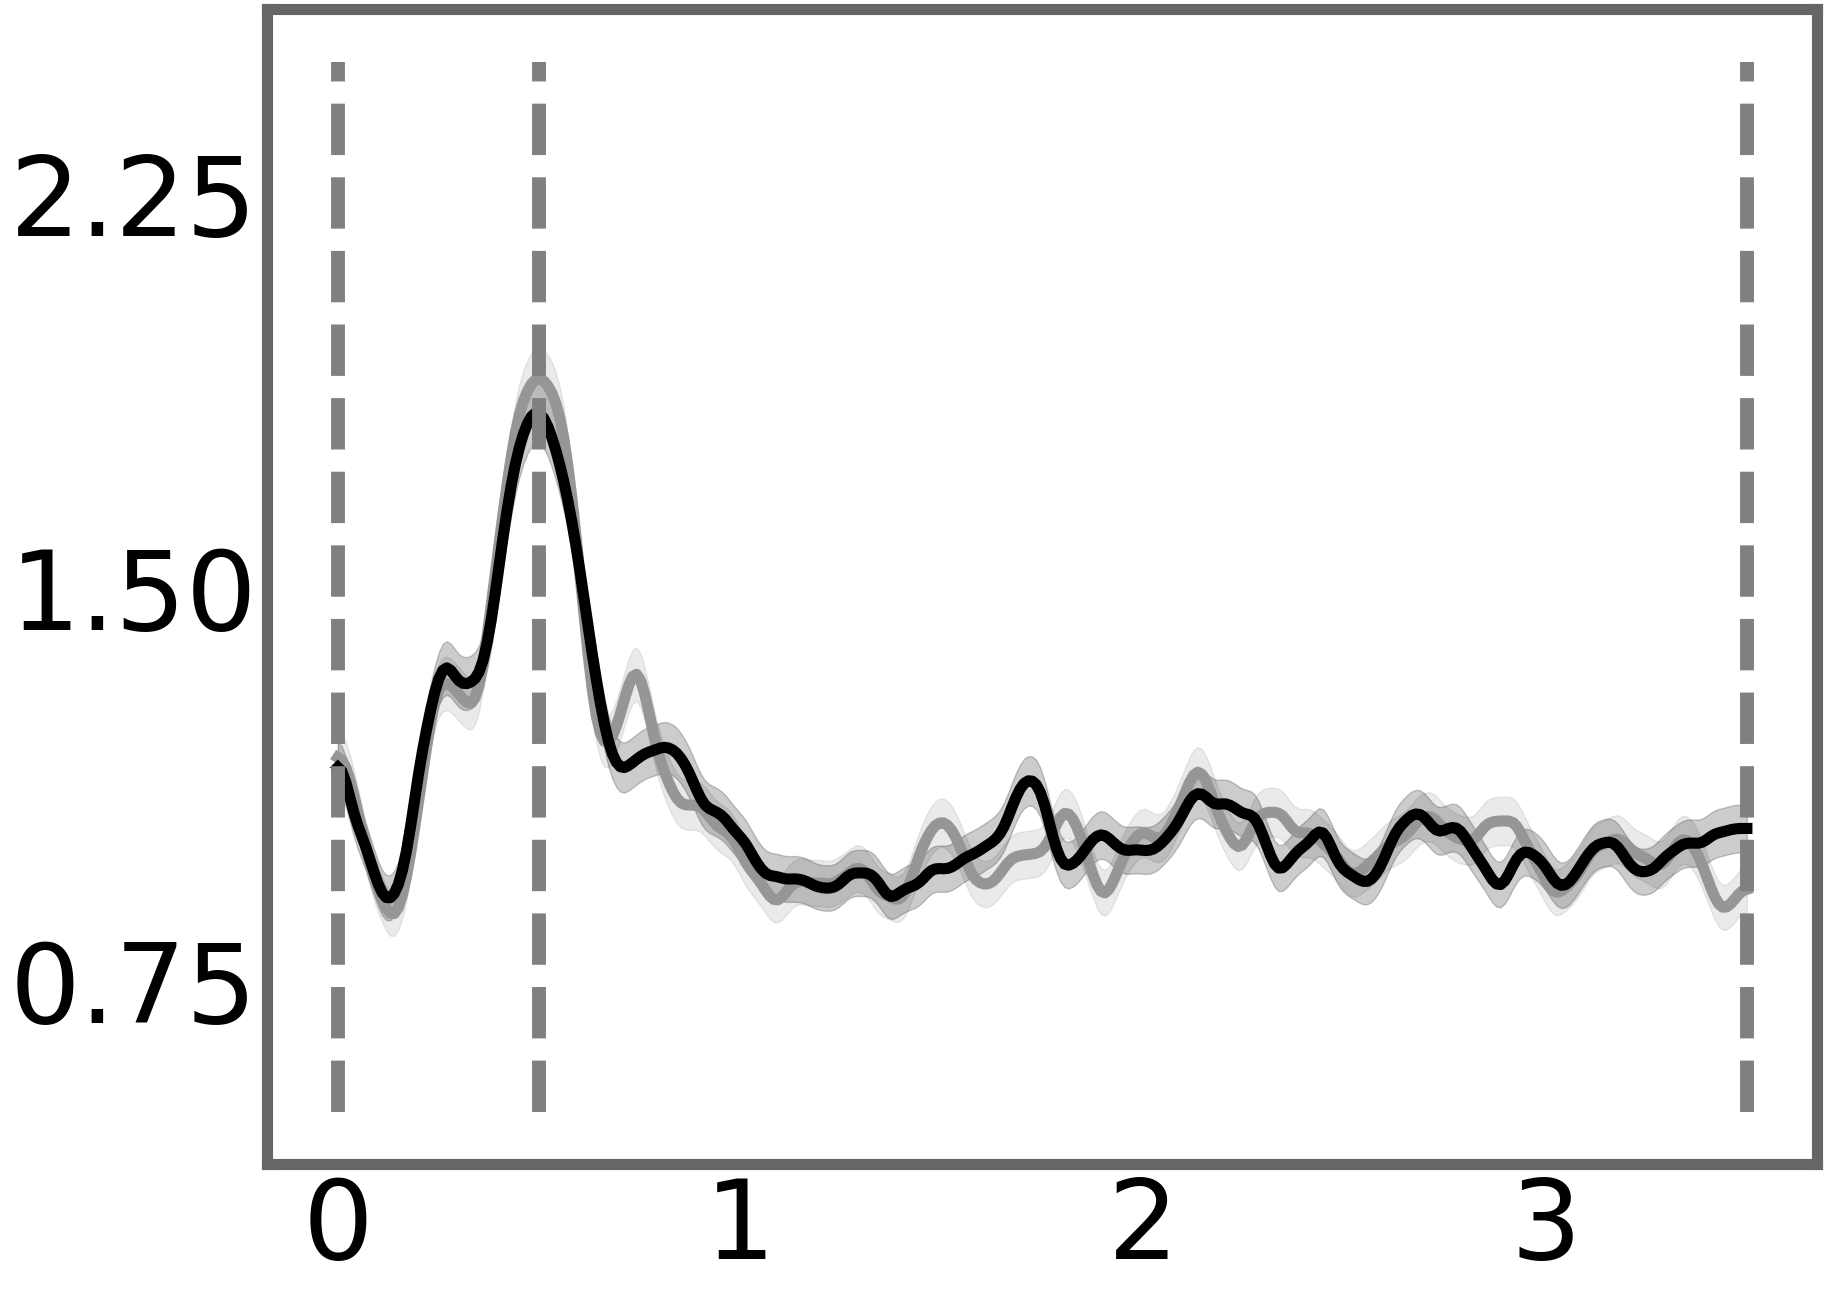

In [35]:
fs(20,15)
fig,ax = plt.subplots()

lenData = 350
x = np.linspace(0,3.5,lenData)
[plt.plot(x,smooth_signal(qq.iloc[i,4001:7501:10],11),c = ["#969696","#000000",][i%2],linestyle = ['dotted','-'][i//2],alpha=[0.8,0.8,1,1,][i],linewidth = 8) for i in [2,3]];
[plt.fill_between(x,smooth_signal(saccUpper.iloc[i,4001:7501:10]),
                       smooth_signal(saccLower.iloc[i,4001:7501:10]),alpha = 0.2,color = ["#969696","#000000",][i%2]) for i in [2,3]]



plt.vlines([0,0.5,3.5],0.5,2.5,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=80)
plt.xticks(fontsize=80)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.75))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)
ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(8)
ax.spines['bottom'].set_linewidth(8)
ax.spines['right'].set_linewidth(8)
ax.spines['top'].set_linewidth(8)